In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, KFold, RepeatedKFold

from utils import plot_confusion_matrix, OneHotEncoder

print(tf.__version__)
print(tf.keras.__version__)

/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pasquale/opt/anaconda3/e

1.14.0
2.2.4-tf


Loading the data of the [SLAC dataset](http://jmir.sourceforge.net/Codaich.html), with 250 MIDI files. The dataset is equally balanced over the classes.

The vectors are computed using [midi2vec](https://github.com/midi-ld/midi2vec).

The dataset provides 2 kind of classes (genres and subgenres), respectively of 5 and 10 elements:

- Blues
    - Modern Blues
    - Traditional Blues
- Classical
    - Baroque
    - Romantic
- Jazz
    - Bop
    - Swing
- Rap
    - Hardcore Rap
    - Pop Rap
- Rock
    - Alternative Rock
    - Metal

In [32]:
df = pd.read_csv('./slac/slac.csv', usecols = ['id','genre', 'subgenre', 'title'])
df

,id,genre,subgenre,title
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...,Blues,Modern,Born Under A Bad Sign
1,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get,Blues,Modern,How Blue Can You Get
2,Blues_-_Modern-B_B_King_-_Rock_Me_Baby,Blues,Modern,Rock Me Baby
3,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone,Blues,Modern,The Thrill Is Gone
4,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door,Blues,Modern,Don't Answer the Door
...,...,...,...,...
245,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...,Rock,Metal,Bulls On Parade
246,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...,Rock,Metal,Guerilla Radio
247,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...,Rock,Metal,Killing In The Name
248,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...,Rock,Metal,Know Your Enemy


We load the following kind of embeddings:
- complete
- without notes
- without program
- without tempo
- without time signature
- taking into account only the first 300 note groups

In [3]:
emb = KeyedVectors.load_word2vec_format('./slac/slac.bin')
emb_notes = KeyedVectors.load_word2vec_format('./slac/slac+notes.bin')
emb_program = KeyedVectors.load_word2vec_format('./slac/slac+program.bin')
emb_tempo = KeyedVectors.load_word2vec_format('./slac/slac+tempo.bin')
emb_ts = KeyedVectors.load_word2vec_format('./slac/slac+ts.bin')
emb_300 = KeyedVectors.load_word2vec_format('./slac/slac_300.bin')

In [4]:
emb_x = [KeyedVectors.load_word2vec_format(f'./slac/slac{i}.bin') for i in range(5)]

In [5]:
ids = df.id.tolist()
data = np.array([emb[i] for i in ids])
data_notes = np.array([emb_notes[i] for i in ids])
data_program = np.array([emb_program[i] for i in ids])
data_tempo = np.array([emb_tempo[i] for i in ids])
data_ts = np.array([emb_ts[i] if i in emb_ts else np.zeros(100) for i in ids ])
data_300 = np.array([emb_300[i] for i in ids])

In [6]:
data_x = []
for j in range(5):
    cur = emb_x[j]
    train_index = [i for i in ids if i in cur]
    test_index = [i for i in ids if i not in cur]
    
    trX = cur[train_index]
    trY = df[df.id.isin(train_index)]
    
    edg_folder = f'./slac/edgelist{j}_test'
    edgelists = [qf for qf in os.listdir(edg_folder)
                 if qf.endswith('.edgelist') and not qf.startswith('_')]
    
    g = None
    for eg in edgelists:
        h = nx.read_edgelist(os.path.join(edg_folder, eg), nodetype=str, create_using=nx.DiGraph(), delimiter=' ')
        for edge in h.edges():
            h[edge[0]][edge[1]]['weight'] = 1

        g = h if g is None else nx.compose(g, h)

    g = g.to_undirected()

    teX = []
    for x in test_index:
        connections = [e[1] for e in list(g.edges(x))]
        vecs = np.array([(emb_x[j][e], 0.4 if e.startswith('g') else (0.2 if not e.startswith('http') else 1))
                         for e in connections if e in emb_x[j]])
        vec = np.average(vecs[:,0], weights=vecs[:,1], axis=0)
        teX.append(vec)
    teY = df[df.id.isin(test_index)]

    data_x.append((trX,trY,teX,teY))

/Users/pasquale/opt/anaconda3/envs/midi/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
emb_sets = {
    'ALL' : data,
    '+N': data_notes,
    '+P': data_program,
    '+T': data_tempo,
    '+TS': data_ts,
    '300': data_300
}

### Experiment 1: Genres 

The labels are represented with the 1-hot encoding

In [8]:
onehot = OneHotEncoder(df.genre.tolist())

onehot.get(onehot.labels[0])

'Blues'

In [9]:
data.shape

(250, 100)

In [10]:
onehot.labels.shape

(250, 5)

In [11]:
num_input = data.shape[1]
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 5)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [12]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                      metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

    return model

In [13]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=10, 
                                 batch_size=50)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [12]:
random_state = 2111
scores_5c = {}
scores_5c_all = {}
for name, d in emb_sets.items():
    print(name)
    scores = cross_val_score(neural_network, d, onehot.labels,
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
    print(scores)
    scores_5c[name] = np.mean(scores)
    scores_5c_all[name] = scores

scores_5c

W0626 10:41:11.099935 4500770240 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


ALL
[0.88       0.88       0.95999998 0.83999997 0.83999997 0.92000002
 0.80000001 0.88       0.75999999 0.88      ]
+N
[0.80000001 0.75999999 0.75999999 0.80000001 0.80000001 0.88
 0.80000001 0.83999997 0.60000002 0.68000001]
+P
[0.80000001 0.75999999 0.80000001 0.83999997 0.68000001 0.68000001
 0.80000001 0.88       0.88       0.83999997]
+T
[0.16       0.28       0.31999999 0.08       0.28       0.36000001
 0.08       0.31999999 0.28       0.2       ]
+TS
[0.31999999 0.2        0.36000001 0.2        0.31999999 0.40000001
 0.12       0.31999999 0.2        0.40000001]
300
[0.95999998 0.80000001 0.83999997 0.80000001 0.83999997 0.92000002
 0.80000001 0.72000003 0.75999999 0.75999999]


{'ALL': 0.863999992609024,
 '+N': 0.772000002861023,
 '+P': 0.7959999978542328,
 '+T': 0.23599999994039536,
 '+TS': 0.2840000011026859,
 '300': 0.8199999988079071}

In [60]:
for name in scores_5c_all:
    print(name, np.std(scores_5c_all[name]))

ALL 0.05425864178174979
+N 0.07599999336842206
+P 0.06799999341176613
+T 0.09541488307386868
+TS 0.09200000217391334
300 0.06985699048771281


Is ALL really better than \*N? Let's try a significance test 

In [ ]:
n_splits=10
n_repeats=10

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
a = cross_val_score(neural_network, data_notes, onehot.labels, cv=cv, n_jobs=-1)
b = cross_val_score(neural_network, data, onehot.labels, cv=cv, n_jobs=-1)

In [23]:
from scipy.stats import t

def significance_test(a, b, alpha = 0.05, verbose=True):
    if verbose:
        print(f'Accuracy of A: {np.mean(a)} ({np.std(a)})')
        print(f'Accuracy of B: {np.mean(b)} ({np.std(b)})')

    x = np.diff((a,b), axis=0)


    n2 = len(data)/n_splits
    n1 = n2*(n_splits-1)
    m = np.mean(x)
    s2 = np.std(x)**2
    kr = n_splits * n_repeats
    t_stat = m / np.sqrt((1/kr + n2/n1) * s2)

    if verbose:
        print(f'T statistic: {t_stat}')
        
    # degrees of freedom
    df = kr - 1
#     cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1 - t.cdf(abs(t_stat), df)) * 2
    
    if verbose:
        print(f'p-value {p}')
        
    # interpret via p-value
    if verbose:
        if p > alpha:
            print('Accept null hypothesis that the means are equal.')
        else:
            print('Reject the null hypothesis that the means are equal.')
    return p > alpha

significance_test(a,b)

Accuracy of A: 0.804799998998642 (0.07699973577627654)
Accuracy of B: 0.8583999967575073 (0.060509833226881964)
T statistic: 2.0005705878426996
p-value 0.04817705740354339
Reject the null hypothesis that the means are equal.


False

In [13]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

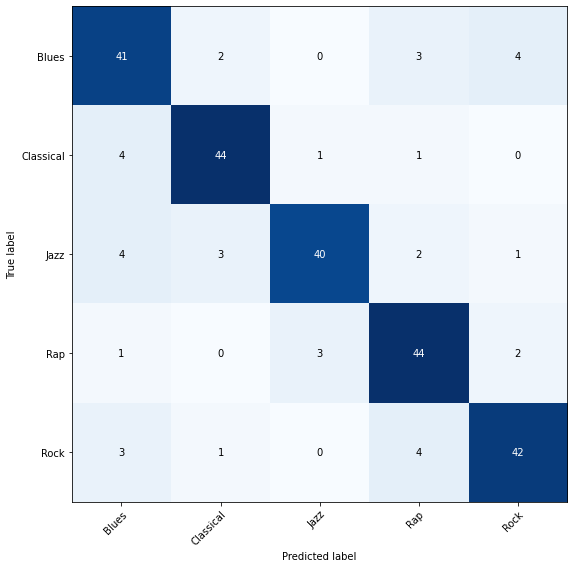

In [14]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre.tolist(), title='slac_genre')

#### Normalized confusion matrix

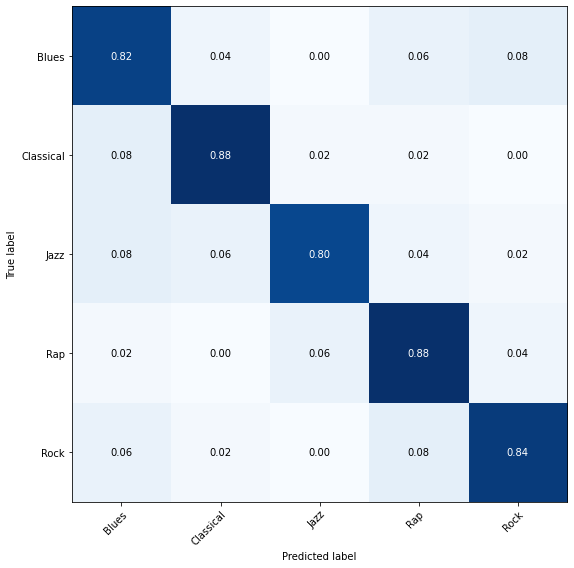

In [15]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.genre.tolist(), normalize=True, title='slac_genre')

### Experiment 1b: Genres (Split)

We perform a new experiment using the train/test split at embedding time

In [29]:
random_state = 2111
scores_5cs = []

t_stat_s ={}
for j in range(5):
    trainX, trainY, testX, testY = data_x[j]
    oh = OneHotEncoder(trainY.genre.tolist()) 

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY = oh.encoder.transform(testY.genre.tolist()) 
    accuracy = neural_network.score(testX, testY, verbose=0)

    scores_5cs.append(accuracy)

print(scores_5cs)
m = np.mean(scores_5cs)
s = np.std(scores_5cs)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.82, 0.7, 0.66, 0.68, 0.8]
Accuracy: 0.732 (0.065)


### Experiment 2: Subgenres 

The experiment is the same, but applied to the 10 subgenre classes.

In [33]:
onehot = OneHotEncoder(df.subgenre.tolist())
    
onehot.get(onehot.labels[0])

'Modern'

In [34]:
num_output = onehot.labels.shape[1]

num_input, num_output

(100, 10)

In [53]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

In [55]:
random_state = 2111
scores_10c = {}
scores_10c_std = {}
for name, d in emb_sets.items():
    print(name)
    scores = cross_val_score(neural_network, d, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
    print(scores)
    scores_10c[name] = np.mean(scores)
    scores_10c_std[name] = np.std(scores)
scores_10c

ALL
[0.56       0.60000002 0.75999999 0.75999999 0.68000001 0.80000001
 0.60000002 0.68000001 0.68000001 0.60000002]
+N
[0.51999998 0.60000002 0.51999998 0.83999997 0.60000002 0.63999999
 0.51999998 0.47999999 0.51999998 0.63999999]
+P
[0.63999999 0.56       0.68000001 0.36000001 0.56       0.51999998
 0.56       0.47999999 0.47999999 0.60000002]
+T
[0.         0.16       0.23999999 0.2        0.08       0.36000001
 0.16       0.2        0.23999999 0.2       ]
+TS
[0.16 0.16 0.08 0.12 0.2  0.16 0.04 0.16 0.12 0.12]
300
[0.75999999 0.56       0.51999998 0.56       0.68000001 0.72000003
 0.56       0.56       0.28       0.60000002]


{'ALL': 0.6720000088214875,
 '+N': 0.5879999905824661,
 '+P': 0.5439999997615814,
 '+T': 0.18400000035762787,
 '+TS': 0.13199999779462815,
 '300': 0.5800000041723251}

In [56]:
scores_10c_std

{'ALL': 0.0775628707594092,
 '+N': 0.09967948517344347,
 '+P': 0.08616263720192893,
 '+T': 0.09156418777837168,
 '+TS': 0.04400000016797676,
 '300': 0.12553884185936923}

In [68]:
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=22)
a = cross_val_score(neural_network, data_notes, onehot.labels, cv=cv, n_jobs=-1)
b = cross_val_score(neural_network, data, onehot.labels, cv=cv, n_jobs=-1)
significance_test(a,b)

Accuracy of A: 0.5904000037908554 (0.09618649227097938)
Accuracy of B: 0.641200004518032 (0.08624709394336039)
T statistic: 1.7728718606254814
p-value 0.07932558237858078
Accept null hypothesis that the means are equal.


True

In [33]:
predicted = cross_val_predict(neural_network, data, onehot.labels, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

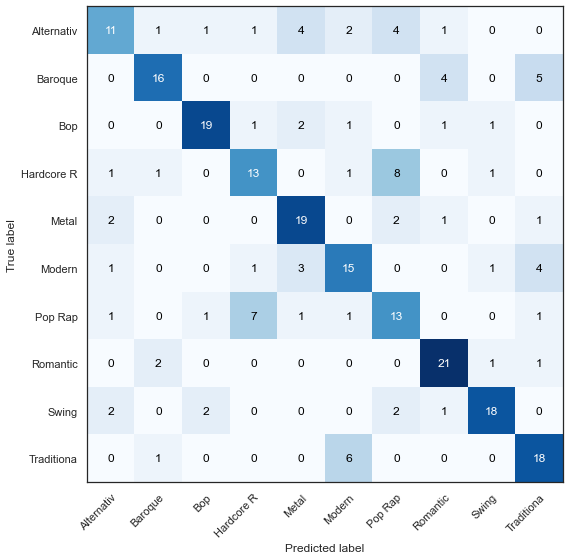

In [34]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.subgenre.tolist(), title="slac_subgenre")

#### Normalized confusion matrix

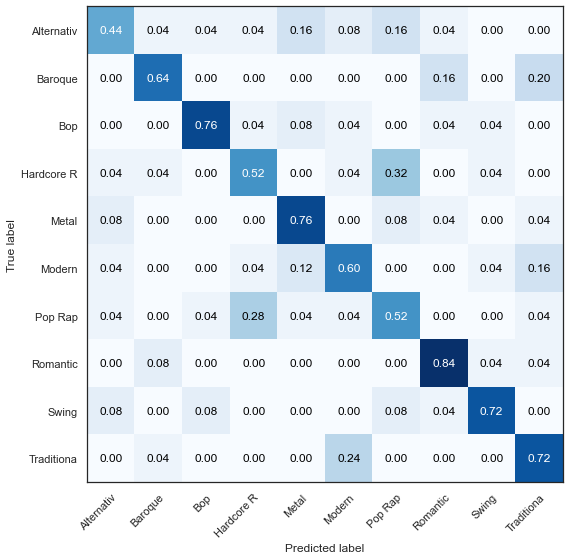

In [35]:
plot_confusion_matrix(onehot.labels, predicted, classes=df.subgenre.tolist(), normalize=True, title="slac_subgenre")

### Experiment 2b: Subgenres (Split)

We perform a new experiment using the train/test split at embedding time

In [78]:
random_state = 2111
scores_10cs = []

t_stat_s ={}
for j in range(5):
    trainX, trainY, testX, testY = data_x[j]
    oh = OneHotEncoder(trainY.subgenre.tolist()) 

    neural_network.fit(trainX, oh.labels, shuffle=True, verbose=0)

    testX = np.array(testX)
    testY = oh.encoder.transform(testY.subgenre.tolist()) 
    accuracy = neural_network.score(testX, testY, verbose=0)

    scores_10cs.append(accuracy)

print(scores_10cs)
m = np.mean(scores_10cs)
s = np.std(scores_10cs)
print('Accuracy: %.3f (%.3f)' % (m, s))

[0.54, 0.5, 0.5, 0.38, 0.58]
Accuracy: 0.500 (0.067)


Export the results for publication

In [36]:
res = pd.DataFrame.from_dict(scores_5c.items())
res.columns=['Approach', '5 classes']
res['10 classes'] = scores_10c.values()
res

,Approach,5 classes,10 classes
0,ALL,0.864,0.672
1,+N,0.772,0.624
2,+P,0.796,0.616
3,+T,0.236,0.188
4,+TS,0.284,0.152
5,300,0.820,0.576


In [37]:
res.to_latex('output/slac.classification.latex',index=False)

# 2D Visualisation with TSNE

Picture saved at ./img/tsne-slac-genre.pdf


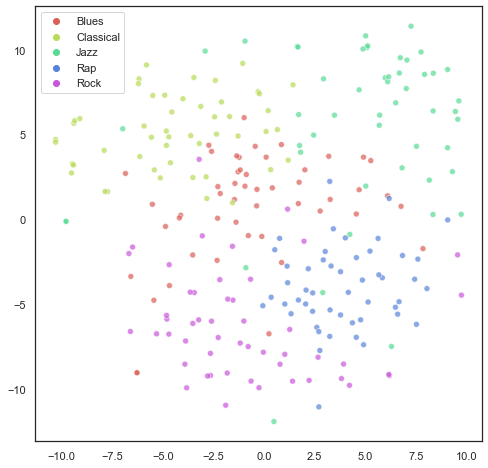

In [38]:
from utils import plot
plot(data, labels=df.genre.tolist(), output='./img/tsne-slac-genre.pdf')

Picture saved at ./img/tsne-slac-subgenre.pdf


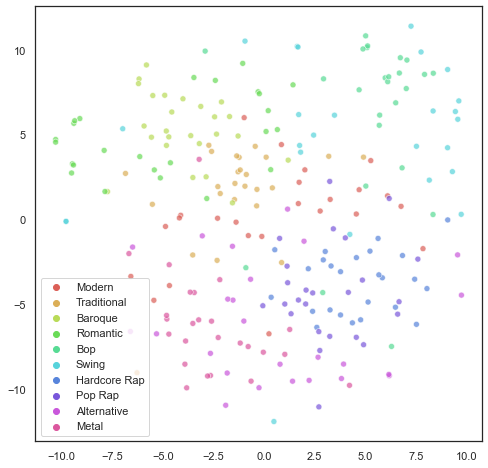

In [39]:
plot(data, labels=df.subgenre.tolist(), output='./img/tsne-slac-subgenre.pdf')